<a href="https://colab.research.google.com/github/GeorgeShmelin/Text-Recognition/blob/MS_mini_project/MS_mini_project_parts1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

## general

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import random
import warnings

In [ ]:
import gc
# gc.collect() are for rubbish collection

### general for modeling

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

--------------------------------------------------------------------------------

# Task 1: Creating a Machine Learning Model

## 1. Data Gathering
    - Using the following dataset, create a dataframe.
    - House Pricing: https://drive.google.com/file/d/1ioITDP2AKAiJ3oM9DzwD-p22wsu2ROM4/view?usp=drive_link

In [ ]:
df_temp = pd.read_csv('https://drive.google.com/uc?id=1ioITDP2AKAiJ3oM9DzwD-p22wsu2ROM4', sep=',')

In [ ]:
df_hp = df_temp.set_index('id')

In [ ]:
'''
ALTERNATIVE

from google.colab import drive
drive.mount('/content/drive')
df_hp = pd.read_csv('/content/house_prices.csv', sep=';', index_col='id')
pd.set_option('display.max_columns', None)
'''

"\nALTERNATIVE\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\ndf_hp = pd.read_csv('/content/house_prices.csv', sep=';', index_col='id')\npd.set_option('display.max_columns', None)\n"

In [ ]:
df_hp.shape

(21613, 20)

In [ ]:
df_hp.sample(5)

date      price  bedrooms  bathrooms  sqft_living  \
id                                                                         
3755100520  20150427T000000   465000.0         3       1.75         1490   
5416300240  20150202T000000   935000.0         4       4.50         5670   
2329800630  20140527T000000   274950.0         3       1.75         1670   
251610020   20150508T000000  1580000.0         4       2.75         3480   
7558800240  20150414T000000   485000.0         4       3.25         1946   

            sqft_lot  floors waterfront  view condition  grade  sqft_above  \
id                                                                           
3755100520     10757     1.0          N     0   Average      7        1060   
5416300240     84267     2.0          N     2   Average     11        5670   
2329800630      7415     1.0          N     0   Average      7        1320   
251610020      19991     2.0          N     2      Good     10        2630   
7558800240     17786     2.0          N     1      Good      7        1946   

            sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
id                                                                             
3755100520            430      1966             0    98034  47.7200 -122.229   
5416300240              0      2008             0    98010  47.3230 -122.044   
2329800630            350      1987             0    98042  47.3776 -122.116   
251610020             850      1979             0    98004  47.6354 -122.214   
7558800240              0      1990             0    98070  47.3590 -122.452   

            sqft_living15  sqft_lot15  
id                                     
3755100520           1490       10609  
5416300240           4100       83729  
2329800630           1650        8585  
251610020            3770       20271  
7558800240           1460       16661

## 2. Data Assessment
    - Evaluate the dataset‚Äôs completeness, consistency, and quality before proceeding.
    - Check the structure of the dataset by inspecting columns, data types, and size.
    - Identify missing values, duplicates, and inconsistencies..
    - Document data quality issues and decide on corrective actions.

and

## 3. Data Cleaning
    - Ensure the dataset is clean, formatted correctly, and ready for analysis.
    - Handle missing values by either removing them, imputing with mean/median/mode, or using advanced techniques like interpolation.
    - Remove duplicate records to avoid bias in the model.
    - Standardize categorical values (e.g., unify spelling variations, encode labels).
    - Convert data types where necessary (e.g., strings to numerical values for analysis).
    - Normalize or scale numerical features if required for certain models

convert the 'date' column into datetime format

In [ ]:
df_hp['date'] = pd.to_datetime(df_hp['date'])

In [ ]:
print("Min date:", df_hp['date'].min())
print("Max date:", df_hp['date'].max())

Min date: 2014-05-02 00:00:00
Max date: 2015-05-27 00:00:00


In [ ]:
df_hp['date'].isnull().sum()

np.int64(0)

quick way to check missing values in all columns

In [ ]:
df_hp.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

automatic downcasting to the smallest possible integer type

In [ ]:
df_hp['price'] = pd.to_numeric(df_hp['price'], downcast='integer')

In [ ]:
print("Data type:", df_hp['price'].dtype)
print("Min price:", df_hp['price'].min())
print("Max price:", df_hp['price'].max())

Data type: int32
Min price: 75000
Max price: 7700000


In [ ]:
df_hp['bedrooms'] = pd.to_numeric(df_hp['bedrooms'], downcast='integer')

In [ ]:
print("Data type:", df_hp['bedrooms'].dtype)
print("Min number of bedrooms:", df_hp['bedrooms'].min())
print("Max number of bedrooms:", df_hp['bedrooms'].max())

Data type: int8
Min number of bedrooms: 0
Max number of bedrooms: 33


Definitions bathrooms:

	‚Ä¢	Full bath: Toilet, sink, shower, and bathtub
	‚Ä¢	3/4 bath (0.75): Toilet, sink, shower only
	‚Ä¢	1/2 bath (0.5): Toilet and sink
	‚Ä¢	1/4 bath (0.25): Usually just a toilet (rare)

In [ ]:
df_hp['bathrooms'] = pd.to_numeric(df_hp['bathrooms'], downcast='float')

In [ ]:
print("Data type:", df_hp['bathrooms'].dtype)
print("Min number of bathrooms:", df_hp['bathrooms'].min())
print("Max number of bathrooms:", df_hp['bathrooms'].max())

Data type: float32
Min number of bathrooms: 0.0
Max number of bathrooms: 8.0


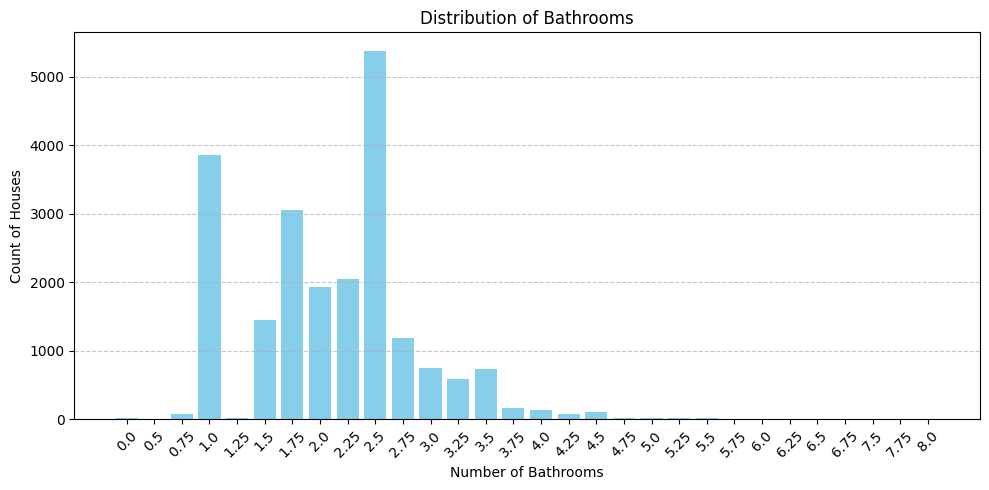

In [ ]:
#pd.DataFrame(sorted(df_hp['bathrooms'].unique()), columns=['Unique Bathrooms'])

bathroom_counts = df_hp['bathrooms'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(bathroom_counts.index.astype(str), bathroom_counts.values, color='skyblue')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count of Houses')
plt.title('Distribution of Bathrooms')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_hp['sqft_living'] = pd.to_numeric(df_hp['sqft_living'], downcast='integer')

In [ ]:
print("Data type:", df_hp['sqft_living'].dtype)
print("Min sqft_living:", df_hp['sqft_living'].min())
print("Max sqft_living:", df_hp['sqft_living'].max())

Data type: int16
Min sqft_living: 290
Max sqft_living: 13540


sqft_lot = total land area (house + garden + garage + all outdoor space)

In [ ]:
df_hp['sqft_lot'] = pd.to_numeric(df_hp['sqft_lot'], downcast='integer')

In [ ]:
print("Data type:", df_hp['sqft_living'].dtype)
print("Min sqft_lot:", df_hp['sqft_lot'].min())
print("Max sqft_lot:", df_hp['sqft_lot'].max())

Data type: int16
Min sqft_lot: 520
Max sqft_lot: 1651359


In [ ]:
df_hp['floors'] = pd.to_numeric(df_hp['floors'], downcast='float')

In [ ]:
print("Data type:", df_hp['floors'].dtype)
print("Min floorst:", df_hp['floors'].min())
print("Max floors:", df_hp['floors'].max())

Data type: float32
Min floorst: 1.0
Max floors: 3.5


In [ ]:
print(df_hp['waterfront'].value_counts())

waterfront
N    21450
Y      163
Name: count, dtype: int64


In [ ]:
df_hp['waterfront'] = df_hp['waterfront'].map({'N': 0, 'Y': 1}).astype(int)

view = 0 basically means ‚Äúno nice view‚Äù

In [ ]:
print(df_hp['view'].value_counts())

view
0    19489
2      963
3      510
1      332
4      319
Name: count, dtype: int64


In [ ]:
df_hp['view'] = pd.to_numeric(df_hp['view'], downcast='integer')
print("Data type:", df_hp['view'].dtype)

Data type: int8


In [ ]:
print(df_hp['condition'].value_counts())

condition
Average      14031
Good          5679
Very Good     1701
Fair           172
Poor            30
Name: count, dtype: int64


In [ ]:
condition_map = {
    'Poor': 0,
    'Fair': 1,
    'Average': 2,
    'Good': 3,
    'Very Good': 4
}
df_hp['condition'] = df_hp['condition'].map(condition_map)
df_hp['condition_encoded'] = df_hp['condition'] - 1  # Shift: poor = 0, excellent = 4
df_hp.drop('condition', axis=1, inplace=True)

df_hp['condition_encoded'] = pd.to_numeric(df_hp['condition_encoded'], downcast='integer')
print("Data type:", df_hp['condition_encoded'].dtype)

Data type: int8


In [ ]:
print(df_hp['grade'].value_counts())

grade
7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: count, dtype: int64


grade refers to the quality of the home‚Äôs construction and design, rated on a scale

In [ ]:
df_hp['grade'] = df_hp['grade'] - 1
df_hp.rename(columns={'grade': 'grade_encoded'}, inplace=True)

In [ ]:
df_hp['grade_encoded'] = pd.to_numeric(df_hp['grade_encoded'], downcast='integer')
print("Data type:", df_hp['grade_encoded'].dtype)

Data type: int8


sqft_above is about livable indoor space above ground

df_hp['total_sqft'] = df_hp['sqft_above'] + df_hp['sqft_basement']

In [ ]:
df_hp['sqft_above'] = pd.to_numeric(df_hp['sqft_above'], downcast='integer')
print("Data type:", df_hp['sqft_above'].dtype)
print("Min sqft_above:", df_hp['sqft_above'].min())
print("Max sqft_above:", df_hp['sqft_above'].max())

Data type: int16
Min sqft_above: 290
Max sqft_above: 9410


In [ ]:
df_hp['sqft_basement'] = pd.to_numeric(df_hp['sqft_basement'], downcast='integer')
print("Data type:", df_hp['sqft_basement'].dtype)
print("Min sqft_basement:", df_hp['sqft_basement'].min())
print("Max sqft_basement:", df_hp['sqft_basement'].max())

Data type: int16
Min sqft_basement: 0
Max sqft_basement: 4820


In [ ]:
df_hp['yr_built'] = pd.to_numeric(df_hp['yr_built'], downcast='integer')
print("Data type:", df_hp['yr_built'].dtype)
print("Min yr_built:", df_hp['yr_built'].min())
print("Max yr_built:", df_hp['yr_built'].max())

Data type: int16
Min yr_built: 1900
Max yr_built: 2015


In [ ]:
print(df_hp['yr_renovated'].value_counts())

yr_renovated
0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1948        1
1951        1
1959        1
1934        1
1944        1
Name: count, Length: 70, dtype: int64


In [ ]:
df_hp['yr_renovated'] = pd.to_numeric(df_hp['yr_renovated'], downcast='integer')
print("Data type:", df_hp['yr_renovated'].dtype)
print("Min yr_renovated:", df_hp['yr_renovated'].min())
print("Max yr_renovated:", df_hp['yr_renovated'].max())

Data type: int16
Min yr_renovated: 0
Max yr_renovated: 2015


"""
This 'neighborhood_score' combines five variables into a single index that reflects
the overall quality of a property's surrounding area: sqft_living15, sqft_lot15,
latitude, longitude, and zipcode.

The concept mirrors the 'grade' column in the dataset, which summarises the
technical condition or finish level of a house without delving into granular
details like construction materials or specific builders. In the same way,
this score simplifies the neighbourhood profile.

Rather than analysing each location characteristic separately, we ask a practical
question: is the area likely to support property value ‚Äî or undermine it?

A lower score typically corresponds to low-value neighbourhoods (often considered
undesirable or underdeveloped), while higher values indicate affluent areas where
larger homes and lots are common, and investment potential is stronger.

This approach makes it easier to treat location quality as a single, interpretable
feature during modelling, reflecting both spatial and social value ‚Äî whether the
area is a 'no-go' or 'next big thing'.
"""

In [ ]:
df_hs = df_hp.copy()

In [ ]:
neighborhood_features = df_hs[['sqft_living15', 'sqft_lot15', 'lat', 'long', 'zipcode']].copy()

# Scale to 0‚Äì1
scaler = MinMaxScaler()
neighborhood_scaled = scaler.fit_transform(neighborhood_features)

# Weighted combination (adjust weights if needed)
df_hs['neighborhood_score'] = (
    neighborhood_scaled[:, 0] * 0.4 +  # sqft_living15
    neighborhood_scaled[:, 1] * 0.2 +  # sqft_lot15
    neighborhood_scaled[:, 2] * 0.2 +  # lat
    neighborhood_scaled[:, 3] * 0.1 +  # long
    neighborhood_scaled[:, 4] * 0.1    # zipcode
)

df_hs.drop(['sqft_living15', 'sqft_lot15', 'lat', 'long', 'zipcode'], axis=1, inplace=True)

In [ ]:
duplicate_index_count = df_hs.index.duplicated().sum()
print(f"Number of duplicate IDs: {duplicate_index_count}")

df_hs = df_hs[~df_hp.index.duplicated()]

Number of duplicate IDs: 177


In [ ]:
df_hs.sample(2)

date   price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id                                                                          
2147300050 2014-08-22  462600         3        2.0         1320      4000   
2491200330 2014-09-18  460000         3        2.5         1690      5131   

            floors  waterfront  view  grade_encoded  sqft_above  \
id                                                                
2147300050     1.0           0     0              5        1020   
2491200330     1.0           0     0              6        1690   

            sqft_basement  yr_built  yr_renovated  condition_encoded  \
id                                                                     
2147300050            300      1940             0                  2   
2491200330              0      1941          1998                  1   

            neighborhood_score  
id                              
2147300050            0.347405  
2491200330            0.225664

In [ ]:
gc.collect()

6804

## 4. Exploratory Data Analysis (EDA)
    - Understand data distribution, relationships, and detect patterns or anomalies.
    - Generate and interpret summary statistics for numerical features (mean, median, variance, outliers).
    - Visualize and interpret distributions using histograms, box plots, and density plots.
    - Identify and interpret relationships between variables using pairplot and correlation heatmaps.

/tmp/ipython-input-47-599788210.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_price_by_month = df_hs.resample('M', on='date')['price'].mean()


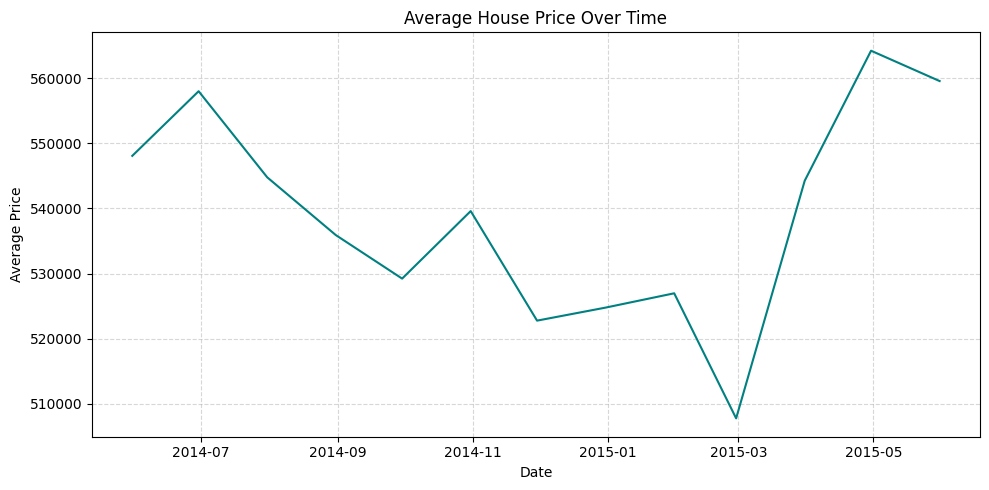

In [ ]:
avg_price_by_month = df_hs.resample('M', on='date')['price'].mean()

plt.figure(figsize=(10, 5))
plt.plot(avg_price_by_month.index, avg_price_by_month.values, color='teal')
plt.title('Average House Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The noticeable dip in average house prices around March 2015 is most likely a data artifact, not a real market crash. This dataset doesn‚Äôt represent the full housing market evenly over time ‚Äî it‚Äôs a snapshot of sales, and some dates (like March 2015) may simply include a higher proportion of cheaper properties, such as smaller homes, foreclosures, or fixer-uppers.

Since we‚Äôre working with raw sales data rather than full market averages, these short-term fluctuations often reflect which types of homes happened to sell in that period ‚Äî not actual changes in property values across the region.

**Therefore, as the dataset represents a static snapshot of property sales rather than a time series of market trends, price prediction is better approached as a regression task based on property features (e.g., size, location, and condition) rather than using time series forecasting methods.**

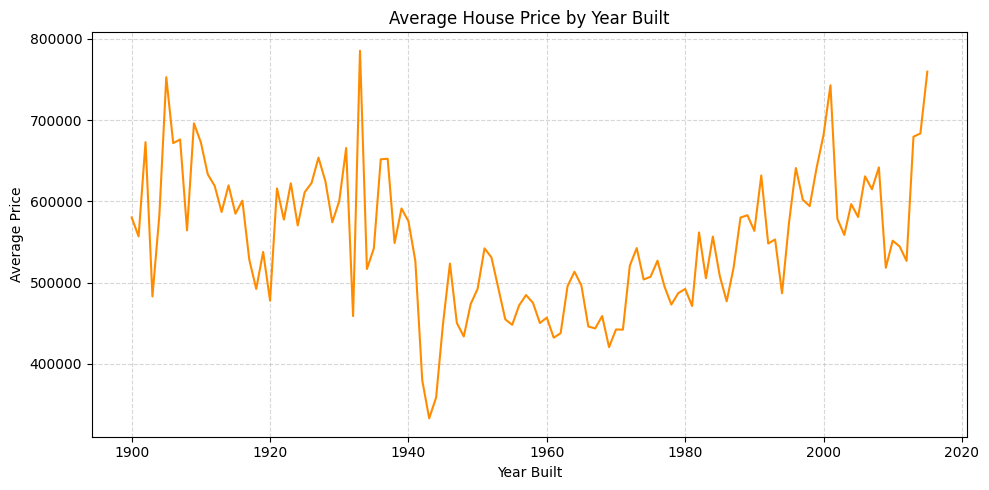

In [ ]:
avg_price_by_year = df_hs.groupby('yr_built')['price'].mean()

plt.figure(figsize=(10, 5))
plt.plot(avg_price_by_year.index, avg_price_by_year.values, color='darkorange')
plt.title('Average House Price by Year Built')
plt.xlabel('Year Built')
plt.ylabel('Average Price')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

the early years (like 1900s) are too noisy or sparse, I can filter them

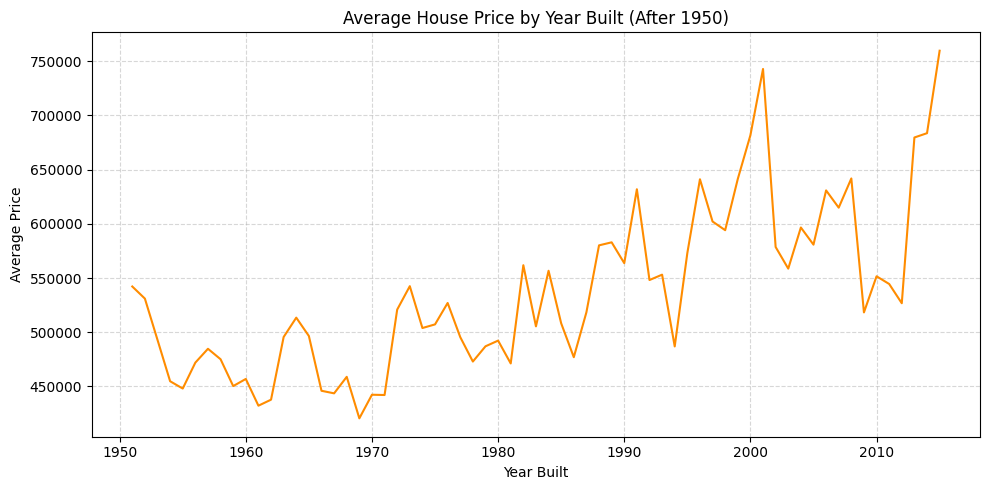

In [ ]:
avg_price_by_year = df_hs[df_hs['yr_built'] > 1950].groupby('yr_built')['price'].mean()

plt.figure(figsize=(10, 5))
plt.plot(avg_price_by_year.index, avg_price_by_year.values, color='darkorange')
plt.title('Average House Price by Year Built (After 1950)')
plt.xlabel('Year Built')
plt.ylabel('Average Price')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Number of Houses per Price Range

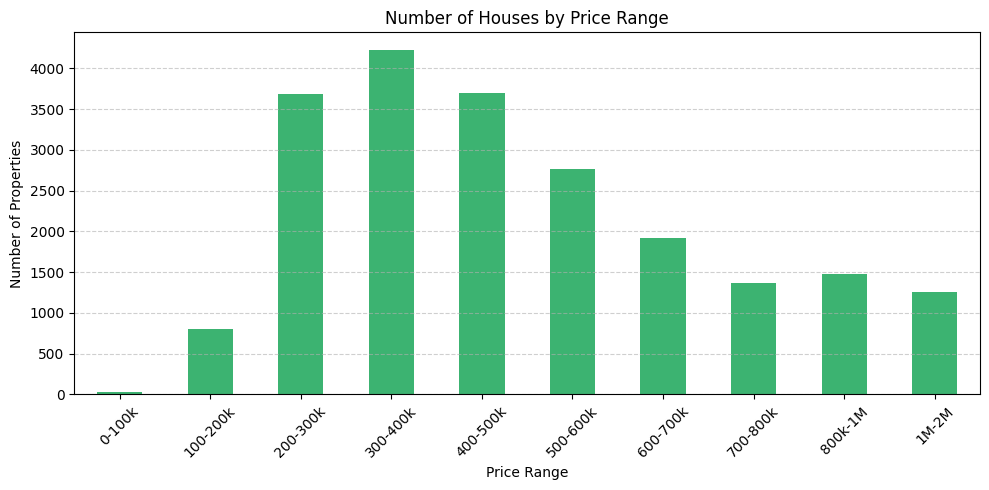

In [ ]:
bins = [0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000,
        700_000, 800_000, 1_000_000, 2_000_000]
labels = ['0-100k', '100-200k', '200-300k', '300-400k', '400-500k',
          '500-600k', '600-700k', '700-800k', '800k-1M', '1M-2M']

df_hs['price_range'] = pd.cut(df_hs['price'], bins=bins, labels=labels)

house_counts = df_hs['price_range'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
house_counts.plot(kind='bar', color='mediumseagreen')
plt.title('Number of Houses by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

sqft_living vs. price Colored by neighborhood_score

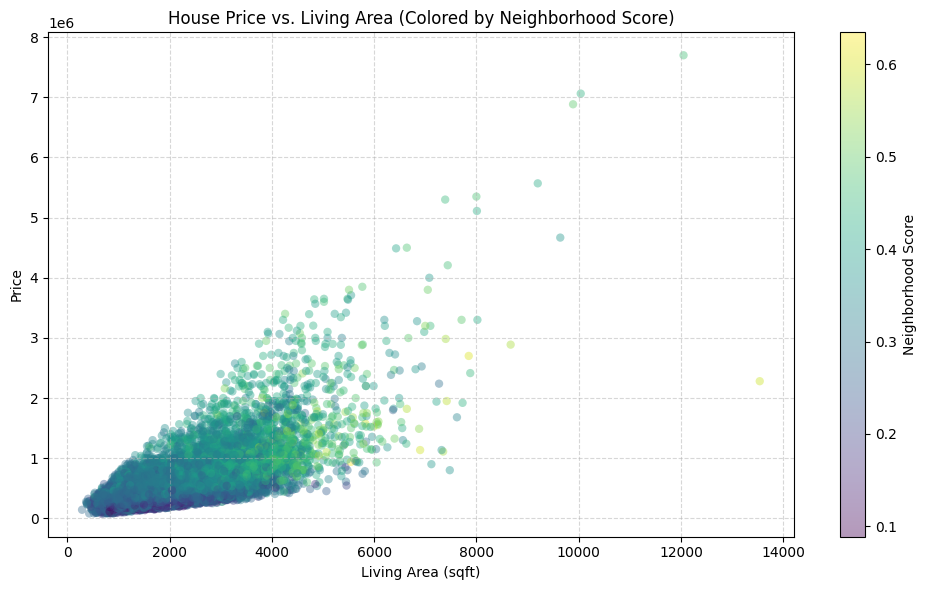

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_hs['sqft_living'],
    df_hs['price'],
    c=df_hs['neighborhood_score'],
    cmap='viridis',
    alpha=0.4,
    edgecolors='none'
)

plt.title('House Price vs. Living Area (Colored by Neighborhood Score)')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Price')
plt.colorbar(scatter, label='Neighborhood Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 5. Build the Predictive Model
    - Select and train a suitable regressor machine learning¬†model using the cleaned dataset.
    - Split the dataset into training and testing sets (typically 70-30 or 80-20 split).
    - Choose an appropriate machine learning algorithm considering the task and the data-
    - Train the model using the training dataset.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Generate indices for train/test from the first split
for train_index, test_index in kf.split(df_hs):
    df_train = df_hs.iloc[train_index]
    df_test = df_hs.iloc[test_index]
    break  # Only take the first split

KFold

In [ ]:
for train_index, test_index in kf.split(df_hs):
    df_train = df_hs.iloc[train_index]
    df_test = df_hs.iloc[test_index]
    break  # Only take the first split

X_train = df_train.drop(['price', 'date', 'price_range'], axis=1)
y_train = df_train['price']

X_test = df_test.drop(['price', 'date', 'price_range'], axis=1)
y_test = df_test['price']

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"üìâ Mean Squared Error: {mse:,.0f}")
print(f"üìà R¬≤ Score: {r2:.4f}")

üìâ Mean Squared Error: 40,236,611,719
üìà R¬≤ Score: 0.6597


Decision Tree (max depth = 5)

In [ ]:
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"üå≥ Decision Tree MSE: {mse_tree:,.0f}")
print(f"üå≥ R¬≤ Score: {r2_tree:.4f}")

üå≥ Decision Tree MSE: 54,098,050,242
üå≥ R¬≤ Score: 0.5425


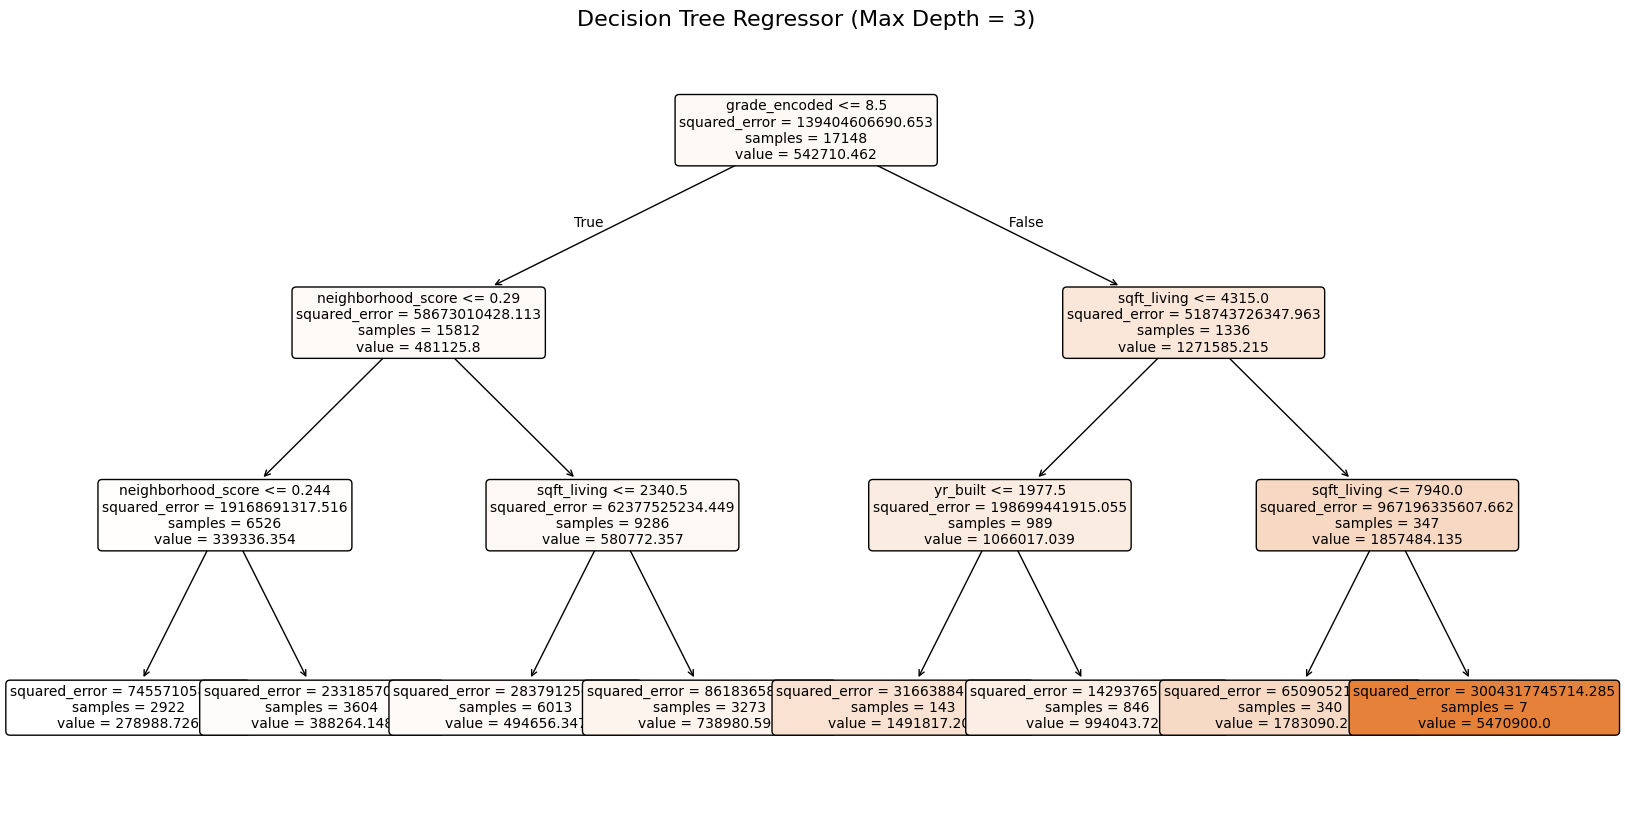

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model,
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Regressor (Max Depth = 3)', fontsize=16)
plt.show()

### K-Means is unsupervised, so it doesn‚Äôt have a prediction score like R¬≤ ‚Äî but I can evaluate how well the clusters fit using

In [ ]:
features_for_clustering = df_hs[['price', 'sqft_living', 'neighborhood_score']].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_hs['cluster'] = clusters

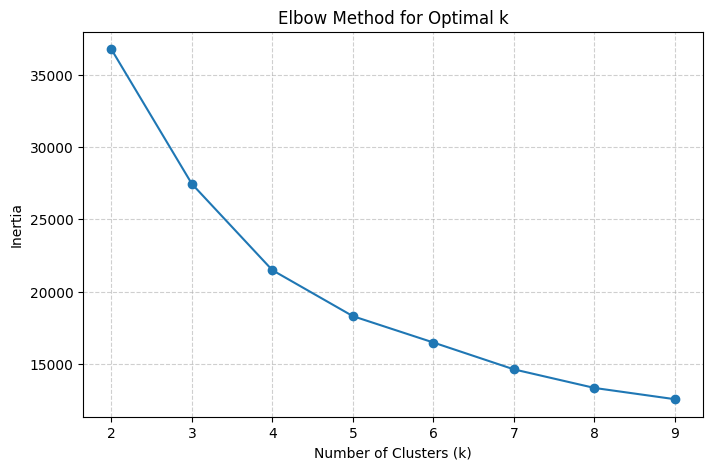

In [ ]:
inertias = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

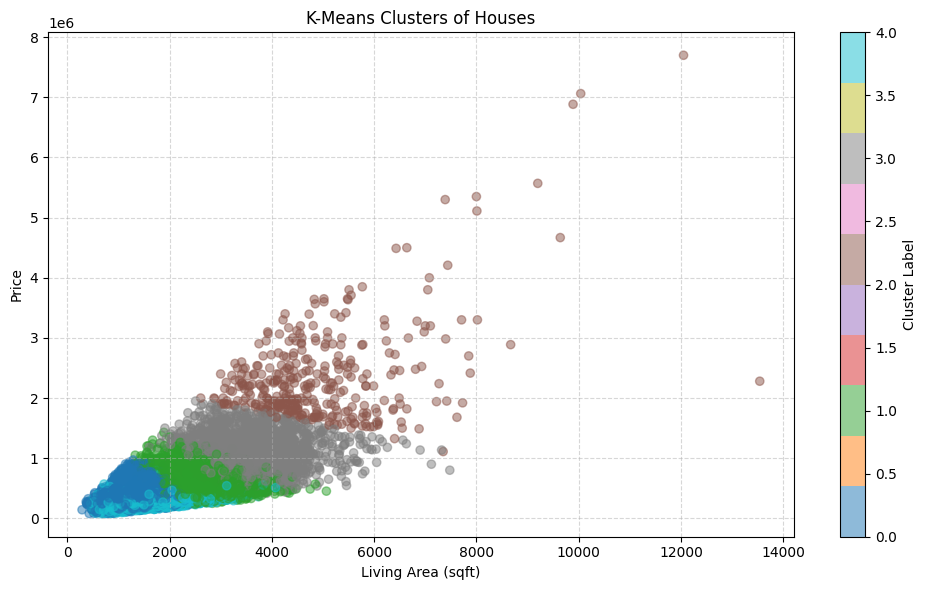

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_hs['sqft_living'],
    df_hs['price'],
    c=df_hs['cluster'],
    cmap='tab10',
    alpha=0.5
)

plt.title('K-Means Clusters of Houses')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Price')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Inertia (Within-Cluster Sum of Squares)

In [ ]:
print(f"Inertia: {kmeans.inertia_:,.0f}")

Inertia: 18,320


	‚Ä¢	Lower = better
	‚Ä¢	Measures how tightly grouped the samples in each cluster are
	‚Ä¢	Not comparable across different datasets ‚Äî only meaningful when testing different numbers of clusters (elbow method)

In [ ]:
sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.3028


	‚Ä¢	Ranges from -1 to 1
	‚Ä¢	Closer to 1 = well-separated, distinct clusters
	‚Ä¢	~0.5 = decent clustering
	‚Ä¢	< 0 = bad clustering (overlap or wrong k)

### Let's try my original df_hp data for K-mean, may my clustering of neighborhoods was a useless idea

In [ ]:
features_for_clustering = df_hp[['price', 'sqft_living', 'zipcode']].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_hp['cluster'] = clusters

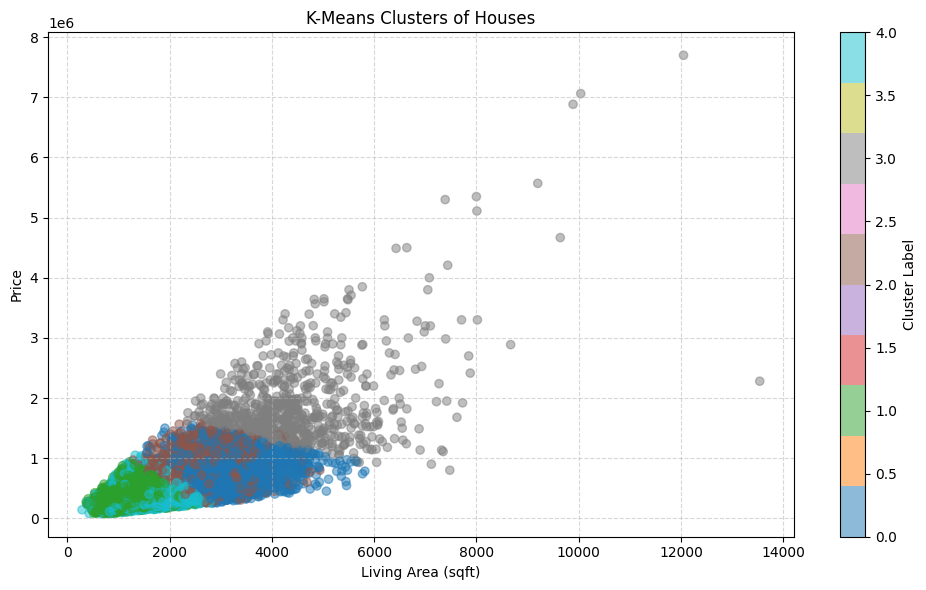

In [ ]:
features_for_clustering = df_hp[['price', 'sqft_living', 'zipcode']].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_hp['cluster'] = clusters

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_hp['sqft_living'],
    df_hp['price'],
    c=df_hp['cluster'],
    cmap='tab10',
    alpha=0.5
)

plt.title('K-Means Clusters of Houses')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Price')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Inertia: {kmeans.inertia_:,.0f}")

Inertia: 19,299


In [ ]:
sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.3732


K-MEAN result based on the original data tends to be a bit better, therefore I should run Random Forest based "price" prediction model

### Random Forest with Hyperparameter Tuning

Features and Target

In [ ]:
features = [
    'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
    'grade_encoded', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'sqft_living15', 'sqft_lot15', 'condition_encoded', 'cluster'
]

X = df_hp[features]
y = df_hp['price']

train_test_split with K-Fold Split

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Only use the first fold for quick comparison (you can loop all folds later if needed)
for train_index, test_index in kf.split(df_hp):
    df_train = df_hp.iloc[train_index]
    df_test = df_hp.iloc[test_index]
    break

X_train = df_train[features]
y_train = df_train['price']

X_test = df_test[features]
y_test = df_test['price']

Hyperparameter Tuning with GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [50, 100],        # fewer trees
    'max_depth': [10, None],          # two levels of depth
    'min_samples_split': [2],         # default value only
    'min_samples_leaf': [1]           # default value only
}

In [ ]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                          # fewer folds
    scoring='neg_mean_squared_error',
    n_jobs=2,                      # limit to 2 cores (or use -1 for all)
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Train Final Model with Best Parameters

In [ ]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Evaluate Model

In [ ]:
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"üìâ Mean Squared Error: {mse:,.0f}")
print(f"üìà R¬≤ Score: {r2:.4f}")

üìâ Mean Squared Error: 26,281,553,972
üìà R¬≤ Score: 0.8262


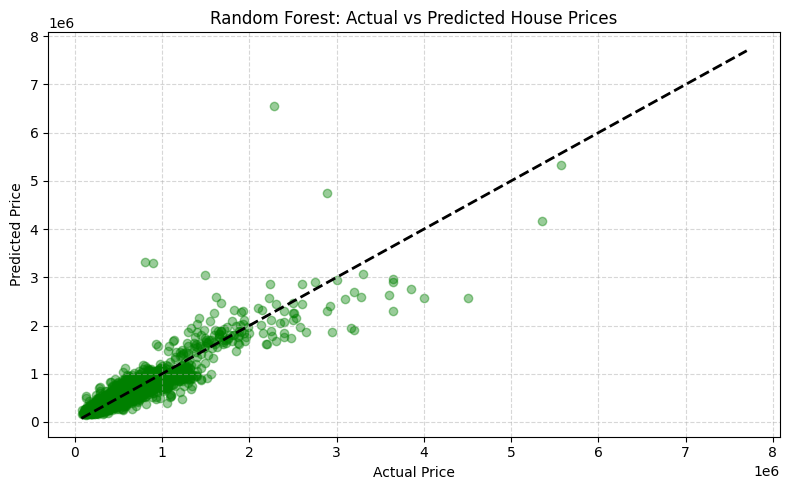

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.4, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted House Prices')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------

# Task 2: Time Series

### 1. Create a Dataframe with the following code and follow the next instructions:

In [ ]:
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as pltimport pandas as pd
from statsmodels.tsa.stattools import adfuller # checks if your time series is stationary
from statsmodels.tsa.arima.model import ARIMA # Most time series models (like ARIMA) require the data to be stationary to work properly
from datetime import datetime, timedelta # a time difference between two dates or times
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Generate 1095 daily dates (approx. 3 years)
dates = [datetime(2020, 1, 1) + timedelta(days=i) for i in range(1095)]

# Create components
trend = np.linspace(0, 30, 1095)                            # Linear upward trend
seasonal = 5 * np.sin(2 * np.pi * np.arange(1095) / 365)   # Annual seasonality
noise = np.random.randn(1095) * 2                          # Random noise

# Final time series values
values = 50 + trend + seasonal + np.cumsum(noise)

# Create DataFrame
df_ts = pd.DataFrame({'Date': dates, 'Value': values})
df_ts.set_index('Date', inplace=True)

print(df_ts.sample(5))

                 Value
Date                  
2020-07-05   47.116349
2022-05-20   84.894722
2022-09-23  109.736662
2020-09-08   50.364048
2022-02-22   59.776327


## 2. Perform Exploratory Data Analysis (EDA)
    - Plot the time series to check for trends or seasonality.
    - Compute summary statistics (mean, variance, min, max) to assess data variability.
    - Check for missing values and handle them if necessary.
    - Use a rolling mean or standard deviation plot to analyze changes over time.

### Plotting Time Series to Check Trend & Seasonality

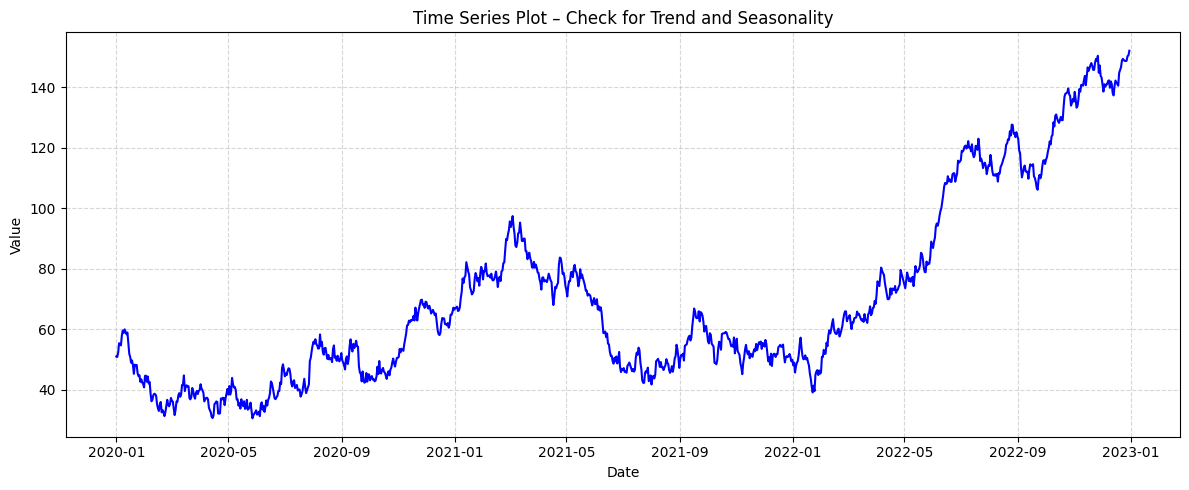

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_ts['Value'], color='blue')
plt.title('Time Series Plot ‚Äì Check for Trend and Seasonality')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Summary Statistics for the Time Series

In [ ]:
mean_val = df_ts['Value'].mean()
var_val = df_ts['Value'].var()
min_val = df_ts['Value'].min()
max_val = df_ts['Value'].max()

print(f"üìä Time Series Summary:")
print(f"Mean:     {mean_val:.2f}")
print(f"Variance: {var_val:.2f}")
print(f"Min:      {min_val:.2f}")
print(f"Max:      {max_val:.2f}")

üìä Time Series Summary:
Mean:     69.78
Variance: 944.90
Min:      30.56
Max:      152.09


### Check for Missing Values

In [ ]:
#import random

df_missing = df_ts.copy()

# Randomly select 20 indices to set as NaN
missing_indices = random.sample(range(len(df_missing)), 20)
df_missing.iloc[missing_indices, df_missing.columns.get_loc('Value')] = np.nan

print(f"üîç Missing values inserted: {df_missing['Value'].isnull().sum()}")

üîç Missing values inserted: 20


Handle Missing Values

In [ ]:
df_missing['Value'] = df_missing['Value'].fillna(df_missing['Value'].mean())
print(f"üîç Missing values inserted: {df_missing['Value'].isnull().sum()}")

üîç Missing values inserted: 0


Rolling Mean and Standard Deviation Plot

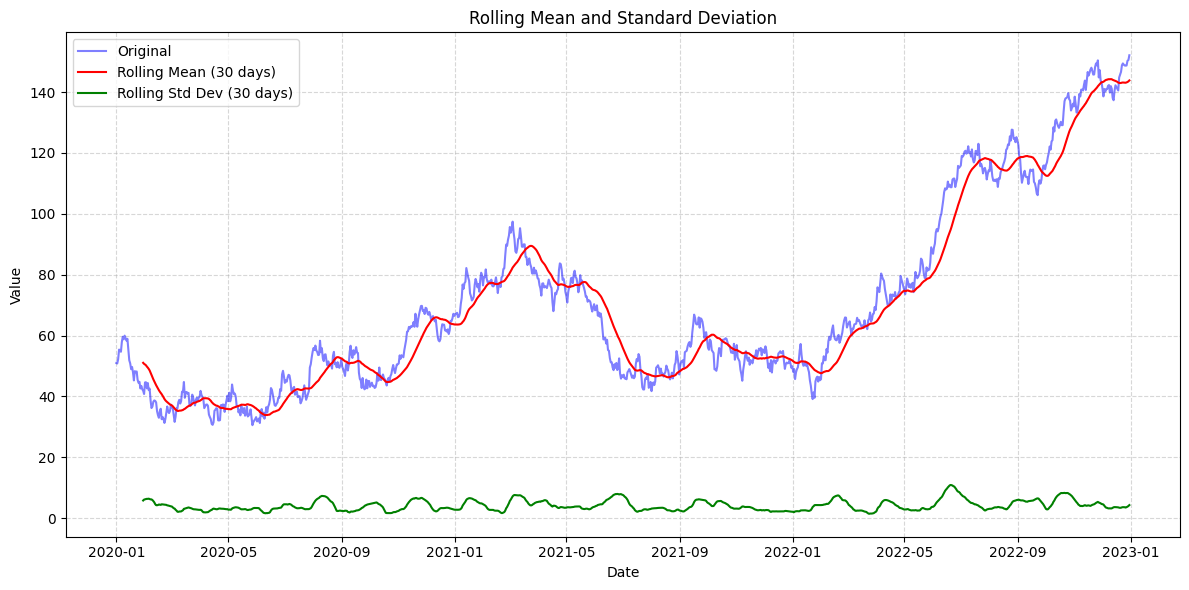

In [ ]:
rolling_mean = df_ts['Value'].rolling(window=30).mean()
rolling_std = df_ts['Value'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(df_ts['Value'], label='Original', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='red')
plt.plot(rolling_std, label='Rolling Std Dev (30 days)', color='green')
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 3. Apply an XGBoost model
    - Initialize the model
    - Split the data and train the model on the training portion of it.
    - Make the predictions on a testing portion of data and calculate an appropriate metric

In [ ]:
ts = df_ts['Value']

Train-test split (80% train, 20% test)

In [ ]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

Hyperparameter tuning (simple grid search for ARIMA)

In [ ]:
#import warnings
warnings.filterwarnings("ignore")

best_score = float('inf')
best_order = None

for p in range(0, 4):
    for d in range(0, 3):
        for q in range(0, 4):
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                preds = model_fit.predict(start=len(train), end=len(ts)-1)
                mse = mean_squared_error(test, preds)
                if mse < best_score:
                    best_score = mse
                    best_order = (p, d, q)
            except:
                continue

print(f'Best ARIMA order: {best_order}, MSE: {best_score:,.2f}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best ARIMA order: (2, 2, 3), MSE: 1,544.67


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit best model and predict

In [ ]:
# Fit model with best parameters
final_model = ARIMA(train, order=best_order)
final_model_fit = final_model.fit()

# Forecast the test period
forecast = final_model_fit.predict(start=len(train), end=len(ts)-1)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plot actual vs. predicted

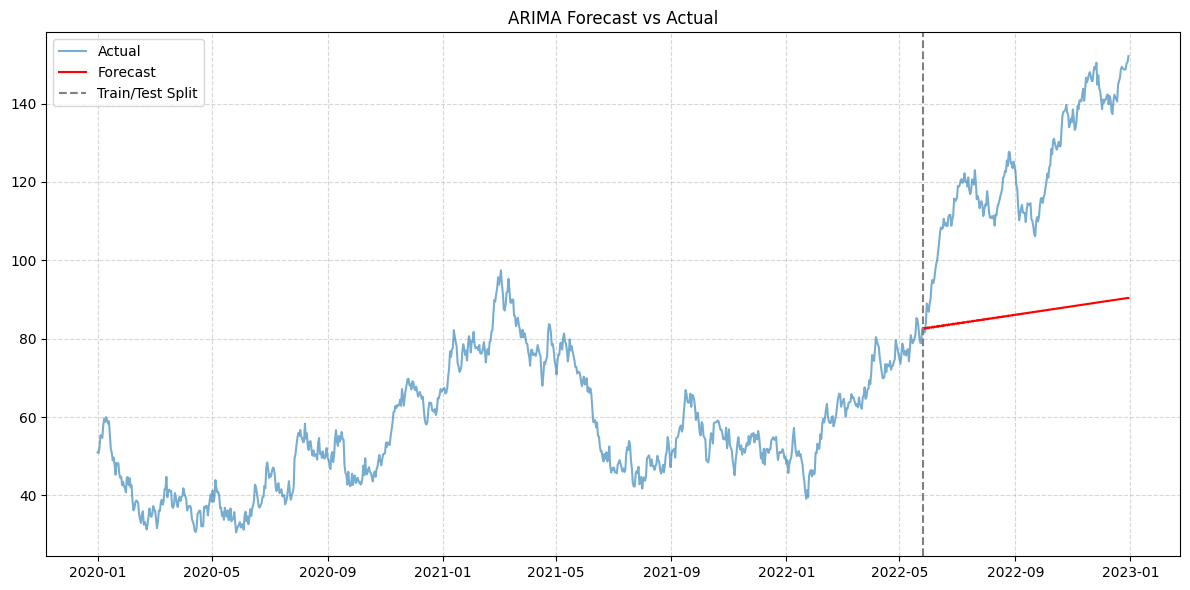

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(ts, label='Actual', alpha=0.6)
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.axvline(ts.index[train_size], color='gray', linestyle='--', label='Train/Test Split')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f"üìâ Mean Squared Error: {mse:,.2f}")
print(f"üìà Mean Absolute Error: {mae:,.2f}")

üìâ Mean Squared Error: 1,544.67
üìà Mean Absolute Error: 36.69


### XGBoost Pipeline with Hyperparameter Tuning (Time Series)

Create lag features (convert time series into supervised format)

In [ ]:
df = df_ts.copy()

# Create lag features (1, 2, 3 days before)
df['lag_1'] = df['Value'].shift(1)
df['lag_2'] = df['Value'].shift(2)
df['lag_3'] = df['Value'].shift(3)

# Drop rows with NaN from lagging
df.dropna(inplace=True)

Train-test split (80% train)

In [ ]:
X = df[['lag_1', 'lag_2', 'lag_3']]
y = df['Value']

train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

Hyperparameter tuning with GridSearchCV and TimeSeriesSplit

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best Params: {grid.best_params_}")

Best Params: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}


Train final model

In [ ]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Make predictions and evaluate

In [ ]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"üìâ Mean Squared Error: {mse:,.2f}")
print(f"üìà Mean Absolute Error: {mae:,.2f}")

üìâ Mean Squared Error: 1,198.44
üìà Mean Absolute Error: 31.01


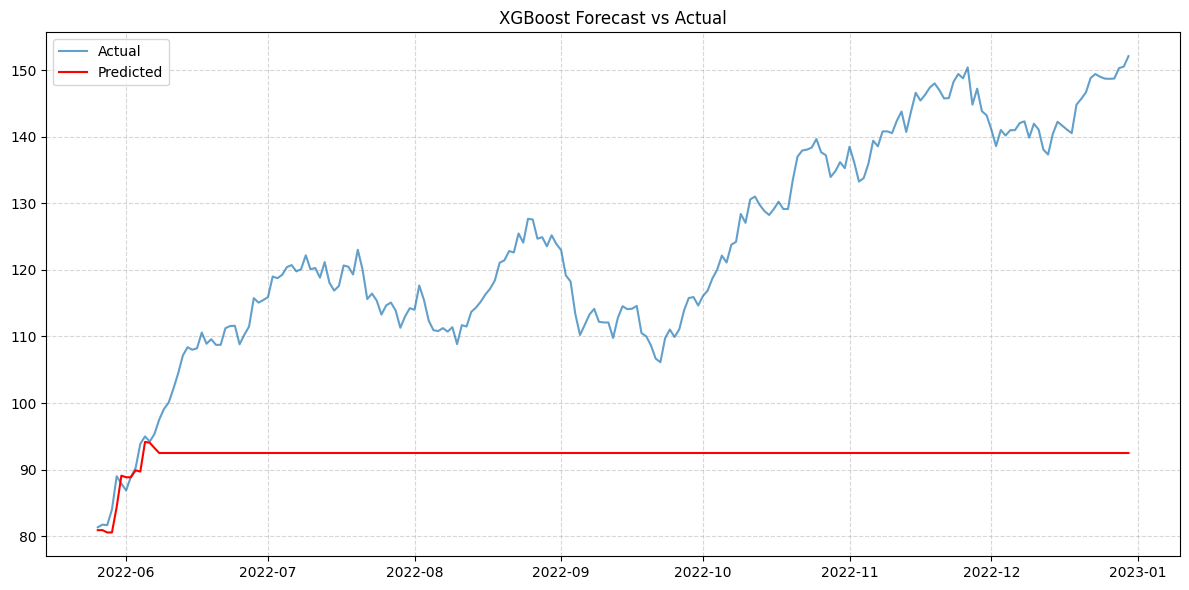

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.title('XGBoost Forecast vs Actual')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()